In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
dpd.fetch_bundles_2_subjects()

Data size is approximately 234MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ariel/.dipy/exp_bundles_and_maps 


({'bundles_2_subjects.tar.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/38477/bundles_2_subjects.tar.gz',
   '97756fbef11ce2df31f1bedf1fc7aac7')},
 '/home/ariel/.dipy/exp_bundles_and_maps')

In [5]:
ls /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/

bundles_af.left.trk   bundles_cg.left.trk     bundles_mdlf.right.trk
bundles_af.right.trk  bundles_cg.right.trk    bundles_slf1.left.trk
bundles_cc_1.trk      bundles_cst.left.trk    bundles_slf1.right.trk
bundles_cc_2.trk      bundles_cst.right.trk   bundles_slf2.left.trk
bundles_cc_3.trk      bundles_ifof.left.trk   bundles_slf2.right.trk
bundles_cc_4.trk      bundles_ifof.right.trk  bundles_slf_3.left.trk
bundles_cc_5.trk      bundles_ilf.left.trk    bundles_slf_3.right.trk
bundles_cc_6.trk      bundles_ilf.right.trk   bundles_uf.left.trk
bundles_cc_7.trk      bundles_mdlf.left.trk   bundles_uf.right.trk


In [7]:
bundle_files = glob('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/*.trk')

In [8]:
def read_sl(fname):
    tgram = load_trk(fname)
    sl = list(dtu.move_streamlines(tgram.streamlines, 
                                   np.eye(4), tgram.affine))
    return sl

# def read_sl(fname, affine):
#     trk = load_trk(fname)
#     sl = trk.streamlines
#     sl = [dts.apply_affine(np.linalg.inv(affine), s) for s in sl]
#     return sl

In [9]:
n_streamlines = []
bundle_name = []
for fname in bundle_files:
    bundle_name.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = read_sl(fname, affine) 
    n_streamlines.append(len(streamlines))

In [10]:
bundle_name

['cg.left',
 'slf1.left',
 'ifof.left',
 'slf2.left',
 'cc_1',
 'cc_2',
 'cst.left',
 'af.left',
 'mdlf.left',
 'uf.right',
 'ilf.left',
 'slf_3.left',
 'cst.right',
 'cc_7',
 'cg.right',
 'cc_6',
 'slf1.right',
 'cc_5',
 'slf2.right',
 'slf_3.right',
 'ilf.right',
 'mdlf.right',
 'uf.left',
 'cc_4',
 'ifof.right',
 'cc_3',
 'af.right']

In [11]:
def reduce_sl(sl):
    """ 
    Reduces a 3D streamline to a binarized 100 x 100 image
    """
    vol = np.zeros(t1_img.shape, dtype=bool)
    sl = np.round(sl).astype(int).T
    vol[sl[0], sl[1], sl[2]] = 1
    # emphasize it a bit:
    vol = binary_dilation(vol, iterations=5)
    vol = resize(vol, (100, 100, 100))
    projected = np.concatenate([np.max(vol, dim) for dim in range(len(vol.shape))])
    projected = resize(projected, (100, 100, 1))
    return projected

In [12]:
np.max(n_streamlines), np.min(n_streamlines), len(n_streamlines)

(15244, 161, 27)

In [13]:
take_n_bundles = len(n_streamlines)

In [14]:
take_n_sl = np.min(n_streamlines)

In [15]:
take_n_bundles = 27
take_n_sl = 160

In [16]:
if op.exists('./subject1_bundles')
    # Read it in from file
    
else:
    data_train = np.zeros((np.int(np.round(take_n_bundles * take_n_sl * 0.6)),  100, 100, 1), dtype='float32')
    data_valid = np.zeros((np.int(np.round(take_n_bundles * take_n_sl * 0.2)),  100, 100, 1), dtype='float32')
    data_test = np.zeros((np.int(np.round(take_n_bundles * take_n_sl * 0.2)),  100, 100, 1), dtype='float32')

    labels_train = np.zeros(np.int(np.round(take_n_bundles * take_n_sl * 0.6)))
    labels_valid = np.zeros(np.int(np.round(take_n_bundles * take_n_sl * 0.2)))
    labels_test = np.zeros(np.int(np.round(take_n_bundles * take_n_sl * 0.2)))

    ii_train = 0
    ii_valid = 0
    ii_test = 0

    tract_id = 0
    for fname in bundle_files:
        tract_id += 1
        if tract_id > take_n_bundles: 
            break
        # Shuffle them in case they are ordered somehow:
        streamlines = read_sl(fname) 
        np.random.shuffle(streamlines)
        choose_sl = streamlines[:take_n_sl]
        for sl_idx, sl in enumerate(choose_sl):
            if np.any(sl < 0):
                print("There are some negative coordinates in %s, track number: %s"%(fname, sl_idx))
            projected = reduce_sl(sl)
            if sl_idx < (np.round(take_n_sl * 0.2)):
                data_test[ii_test] = projected
                labels_test[ii_test] = tract_id
                ii_test += 1
            elif sl_idx < (np.round(take_n_sl * 0.4)):
                data_valid[ii_valid] = projected
                labels_valid[ii_valid] = tract_id
                ii_valid += 1
            else:
                data_train[ii_train] = projected
                labels_train[ii_train] = tract_id
                ii_train += 1

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk, track number: 0
There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk, track number: 1
There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk, track number: 2
There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk, track number: 3
There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk, track number: 4
There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/bundles_cst.left.trk, track number: 5
There are some negative coordinates in /home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/sub

In [18]:
img_rows = 100
img_cols = 100
batch_size = 4
epochs = 12
num_classes = take_n_bundles
input_shape = (img_rows, img_cols, 1)

In [19]:
labels_train = keras.utils.to_categorical(labels_train-1, num_classes)
labels_valid = keras.utils.to_categorical(labels_valid-1, num_classes)
labels_test  = keras.utils.to_categorical(labels_test-1, num_classes)

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [22]:
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_valid, labels_valid))

Train on 2592 samples, validate on 864 samples
Epoch 1/12
2592/2592 [==============================] - 57s - loss: 0.7031 - acc: 0.8040 - val_loss: 0.2177 - val_acc: 0.9236
Epoch 2/12
2592/2592 [==============================] - 55s - loss: 0.2918 - acc: 0.9101 - val_loss: 0.1851 - val_acc: 0.9375
Epoch 3/12
2592/2592 [==============================] - 55s - loss: 0.2218 - acc: 0.9263 - val_loss: 0.1694 - val_acc: 0.9363
Epoch 4/12
2592/2592 [==============================] - 55s - loss: 0.1734 - acc: 0.9479 - val_loss: 0.1664 - val_acc: 0.9375
Epoch 5/12
2592/2592 [==============================] - 54s - loss: 0.1714 - acc: 0.9414 - val_loss: 0.1672 - val_acc: 0.9444
Epoch 6/12
2592/2592 [==============================] - 55s - loss: 0.1627 - acc: 0.9425 - val_loss: 0.1561 - val_acc: 0.9421
Epoch 7/12
2592/2592 [==============================] - 55s - loss: 0.1347 - acc: 0.9468 - val_loss: 0.1486 - val_acc: 0.9502
Epoch 8/12
2592/2592 [==============================] - 55s - loss: 0.1

In [23]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [24]:
print(score)

[0.13885204824919128, 0.95601851851851849]


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

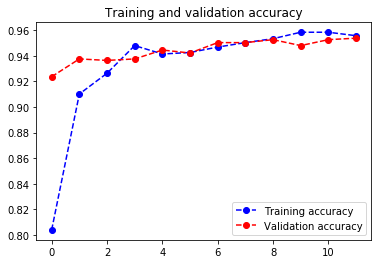

In [26]:
accuracy = training.history['acc']
val_accuracy = training.history['val_acc']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo--', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

In [28]:
np.savez('./subject1_bundles', {'data_train':data_train, 'labels_train': labels_train,
                                'data_test':data_test, 'labels_test': labels_test, 
                                'data_valid':data_valid, 'labels_valid': labels_valid})

Cross-predict on *another subject*

In [ ]:
sub2_bundle_files = glob('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/bundles/*.trk')

In [31]:
sub2_t1_img = nib.load('/home/ariel/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/t1_warped.nii.gz')

In [50]:
n_streamlines = 0
for fname in sub2_bundle_files:
    streamlines = read_sl(fname, np.linalg.inv(sub2_t1_img.affine))
    n_streamlines += len(streamlines)

In [51]:
n_streamlines

57060

In [ ]:
data_sub2 = np.zeros((n_streamlines, 100, 100, 1))
#predictions = []
#actual_labels = []
ii = 0
for fname in sub2_bundle_files:
    bundle_name = fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0]
    print(bundle_name)
    streamlines = read_sl(fname, np.linalg.inv(sub2_t1_img.affine))
    for sl in streamlines: 
        data_sub2[ii] = reduce_sl(sl)
        ii += 1
        if not np.mod(ii, 100):
            print("ii = %s"%ii)
        actual_labels.append(bundle_name)

cg.left


/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


ii = 100
ii = 200
ii = 300
ii = 400
ii = 500
ii = 600
ii = 700
ii = 800
ii = 900
ii = 1000
ii = 1100
ii = 1200
ii = 1300
ii = 1400
ii = 1500
ii = 1600
ii = 1700
ii = 1800
ii = 1900
ii = 2000
ii = 2100
ii = 2200
ii = 2300
ii = 2400
ii = 2500
ii = 2600
ii = 2700
ii = 2800
ii = 2900
ii = 3000
ii = 3100
ii = 3200
ii = 3300
ii = 3400
ii = 3500
ii = 3600
ii = 3700
ii = 3800
ii = 3900
slf1.left
ii = 4000
ii = 4100
ii = 4200
ii = 4300
ii = 4400
ii = 4500
ii = 4600
ii = 4700
ii = 4800
ii = 4900
ifof.left
ii = 5000
ii = 5100
ii = 5200
ii = 5300
ii = 5400
ii = 5500
ii = 5600
ii = 5700
ii = 5800
slf2.left
ii = 5900
ii = 6000
ii = 6100
ii = 6200
ii = 6300
ii = 6400
ii = 6500
ii = 6600
cc_1
ii = 6700
ii = 6800
ii = 6900
ii = 7000
ii = 7100
cc_2
ii = 7200
ii = 7300
ii = 7400
ii = 7500
ii = 7600
ii = 7700
ii = 7800
ii = 7900
cst.left
ii = 8000
ii = 8100
ii = 8200
ii = 8300
ii = 8400
ii = 8500
ii = 8600
ii = 8700
ii = 8800
ii = 8900
ii = 9000
ii = 9100
ii = 9200
ii = 9300
ii = 9400
ii = 9500
ii = 9600


In [40]:
p = model.predict(projected[np.newaxis], batch_size=4)
predictions.append(bundle_name[np.argmax(p)])

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

In [45]:
arr_pred = np.array(predictions)
arr_act = np.array(actual_labels)

In [48]:
correct = arr_pred == arr_act[:-1]

In [49]:
np.mean(correct)

0.91444015444015447

In [ ]:
from sklearn.metrics import cohen_kappa_score